# Setup

In [7]:
import gc
gc.collect()

7

In [8]:
import os
import cv2
import torch
import csv
import torchvision.models as models
import torch.nn as nn
import torch.utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import albumentations as albu
import pandas as pd
import numpy as np
import time
import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random
import re
import plotly.express as px
from tqdm.notebook import tqdm
import shutil

In [9]:
from utils.utility import *
from networks.crossdomain_dynamic import *
from binning import *

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
%matplotlib inline
pd.set_option('max_colwidth', 600)

### Setting paths

In [12]:
path_root = 'data'
path_h5 = os.path.join(path_root, 'h5')
path_noon = os.path.join(path_h5, 'noon.hdf5')
path_night = os.path.join(path_h5, 'night.hdf5')
path_evening = os.path.join(path_h5, 'sunset.hdf5')
path_rainy_noon = os.path.join(path_h5, 'rainy_noon.hdf5')

path_noon_2 = os.path.join(path_h5, 'noon2.hdf5')
path_night_2 = os.path.join(path_h5, 'night2.hdf5')
path_evening_2 = os.path.join(path_h5, 'sunset2.hdf5')
path_rainy_noon_2 = os.path.join(path_h5, 'rainy_noon2.hdf5')

path_save = os.path.join(path_root, 'saved')
path_models = os.path.join(path_save, 'models')
path_dump = os.path.join(path_save, 'logs')
path_embeddings = os.path.join(path_save, 'embeddings')

In [13]:
# For reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

### Loading image arrays and precalculated statistics

In [14]:
arr_noon_images = get_image_arr(path_noon)
arr_night_images = get_image_arr(path_night)
arr_evening_images = get_image_arr(path_evening)
arr_rainy_noon_images = get_image_arr(path_rainy_noon)

arr_noon_2_images = get_image_arr(path_noon_2)
arr_night_2_images = get_image_arr(path_night_2)
arr_evening_2_images = get_image_arr(path_evening_2)
arr_rainy_noon_2_images = get_image_arr(path_rainy_noon_2)

len_ds = arr_noon_images.shape[0]

In [15]:
# mean, std
stats_noon = np.array([[0.47357196, 0.47686451, 0.48483694], [0.26173203, 0.26308321, 0.2692394]])   
stats_night = np.array([[0.13137933, 0.11963478, 0.10502443], [0.12839897, 0.11902827, 0.10177771]]) 
stats_evening = np.array([[0.19001904, 0.17853512, 0.17442669], [0.13858961, 0.12995696, 0.1299348]])
stats_rainy_noon = np.array([[0.28693173, 0.28569815, 0.29263077], [0.13959084, 0.14426025, 0.15149498]])

# Loading embeddings

In [16]:
embeddings = np.load(path_embeddings+'/static_embeddings.npy')

# Loading model

In [17]:
gc.collect()
use_cuda = True
model = DynamicNet(None, ['night', 'evening', 'rainy_noon'])

Keys of dynamic extractors: dict_keys(['night', 'evening', 'rainy_noon'])


In [18]:
path_folder_model = os.path.join(path_models, 'multi-domain-test')
model.load(path_folder_model, flag_inference=True)

Loaded from data/saved/models/multi-domain-test sucessfully!


# Inference via binning

### Parameters

In [19]:
bin_size = 50
sequence_size = 3
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=stats_night[0], 
                                 std=stats_night[1])

### Load images from database

In [23]:
list_bins = get_bin_ids(len(arr_evening_images), bin_size)

In [25]:
list_noon_bin_sequence_images = list()

for i in tqdm(list_bins[3:]):
    list_noon_bin_sequence_images.append([get_input_embedding(embedding) for embedding 
                                          in embeddings[i: i + sequence_size]])

100%|██████████| 25/25 [00:00<00:00, 19300.13it/s]


In [26]:
# Noon images
list_noon_bin_images = list()
for i in tqdm(list_bins[3:]):
    list_noon_bin_images.append(get_input_embedding(embeddings[i]))

100%|██████████| 25/25 [00:00<00:00, 33214.32it/s]


In [27]:
list_night_images_2 = [get_input_img(night_image, normalize, to_tensor) for night_image 
                       in tqdm(arr_night_2_images[150:])]

100%|██████████| 1205/1205 [00:00<00:00, 1449.40it/s]


### Setting night extractor and testing a bin-img pair

In [111]:
model.set_feature_extractor('night')
model._set_eval();

In [112]:
get_similarity(model, list_noon_bin_images[1], list_night_images_2[50])

0.9309316

### Running the Bin-Matching Algorithm

In [114]:
dump  = os.path.join(path_dump, 'dump.npy')
list_night_images = list_night_images_2

In [115]:
# Binning algorithm works as follows: It iterates over the dynamic set that is list_night_images_2,
# For every image, it checks similarity with the current bin representative image and the next bin representative image
# If similarity with next bin number is greater then curr_noon_image_bin_number += 1
# Else, all stays the same
# Now if true bin value is farther than predicted bin value be more than equal to 1, then we count it as an erroneous hit

def find_new_accuracy_base():
    curr_noon_image_bin_number = 0
    error = 0
    graph_arrays = list()
    # graph_arrays = list(graph_arrays)
    for i in range(0, len(list_night_images) + sequence_size):
        # try:
        night_image_seq = list_night_images[i: i + sequence_size]
        night_image_number = i + 1
        # night_image_number = int(list_night_images[i].filename.split('/')[-1][0:-4]) # for gaussian images
        noon_image_bin_number_corresponding_to_current_night_image = get_bin_number_from_image_number(night_image_number)

        similarity1 = get_sequence_similarity(model, night_image_seq, list_noon_bin_sequence_images[curr_noon_image_bin_number])
        similarity2 = get_sequence_similarity(model, night_image_seq, list_noon_bin_sequence_images[(curr_noon_image_bin_number + 1)])

        if similarity2 > similarity1 and curr_noon_image_bin_number < len(list_noon_bin_sequence_images) - 2:
            curr_noon_image_bin_number += 1

        if abs(curr_noon_image_bin_number - noon_image_bin_number_corresponding_to_current_night_image) >= 2:
            error += 1

        graph_arrays.append((error, noon_image_bin_number_corresponding_to_current_night_image, curr_noon_image_bin_number))

        if i % 10 == 0: 
            print(f'Error: {error}, Current Night Image Number: {night_image_number}, Current Day Image Bin Number: {curr_noon_image_bin_number}')
            np.save(dump, graph_arrays) 
    return graph_arrays

In [117]:
graph_arrays = find_new_accuracy_base()

Error: 0, Current Night Image Number: 1, Current Day Image Bin Number: 1
Error: 0, Current Night Image Number: 11, Current Day Image Bin Number: 1
Error: 0, Current Night Image Number: 21, Current Day Image Bin Number: 1
Error: 0, Current Night Image Number: 31, Current Day Image Bin Number: 1
Error: 0, Current Night Image Number: 41, Current Day Image Bin Number: 1
Error: 0, Current Night Image Number: 51, Current Day Image Bin Number: 1
Error: 0, Current Night Image Number: 61, Current Day Image Bin Number: 1
Error: 0, Current Night Image Number: 71, Current Day Image Bin Number: 1
Error: 0, Current Night Image Number: 81, Current Day Image Bin Number: 1
Error: 0, Current Night Image Number: 91, Current Day Image Bin Number: 1
Error: 0, Current Night Image Number: 101, Current Day Image Bin Number: 1
Error: 0, Current Night Image Number: 111, Current Day Image Bin Number: 1
Error: 0, Current Night Image Number: 121, Current Day Image Bin Number: 1
Error: 0, Current Night Image Number

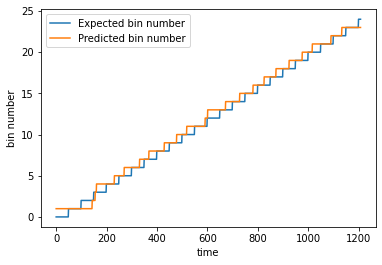

In [118]:
plt.plot([i for i in range(len(graph_arrays))], [i[1] for i in graph_arrays], label='Expected bin number')
plt.plot([i for i in range(len(graph_arrays))], [i[2] for i in graph_arrays], label='Predicted bin number')
plt.xlabel('time')
plt.ylabel('bin number')
plt.legend()

Our model gives 0 error with the current binning evaluation method, having bin size = 50 and sequence size = 3,
this is much better than the previous implement model which was just a N-branch CNN with no siamese pretraining. 
In the previous model, even running sequence size = 15 give around 100 errorenous hits.